Необходимо предсказать температуру на каждый день в течение следующих 730 дней.

Чтобы выполнить задание, вам следует создать файл формата .csv, в котором будет одна колонка с названием Temperature. В этой колонке должны содержаться 730 предсказанных значений температуры.

In [9]:
import pandas as pd
import numpy as np
csv_file_path = r"C:\Users\spot2\Downloads\temperature.csv"

#Чтение файла в dataframe c данными
df = pd.read_csv(csv_file_path)



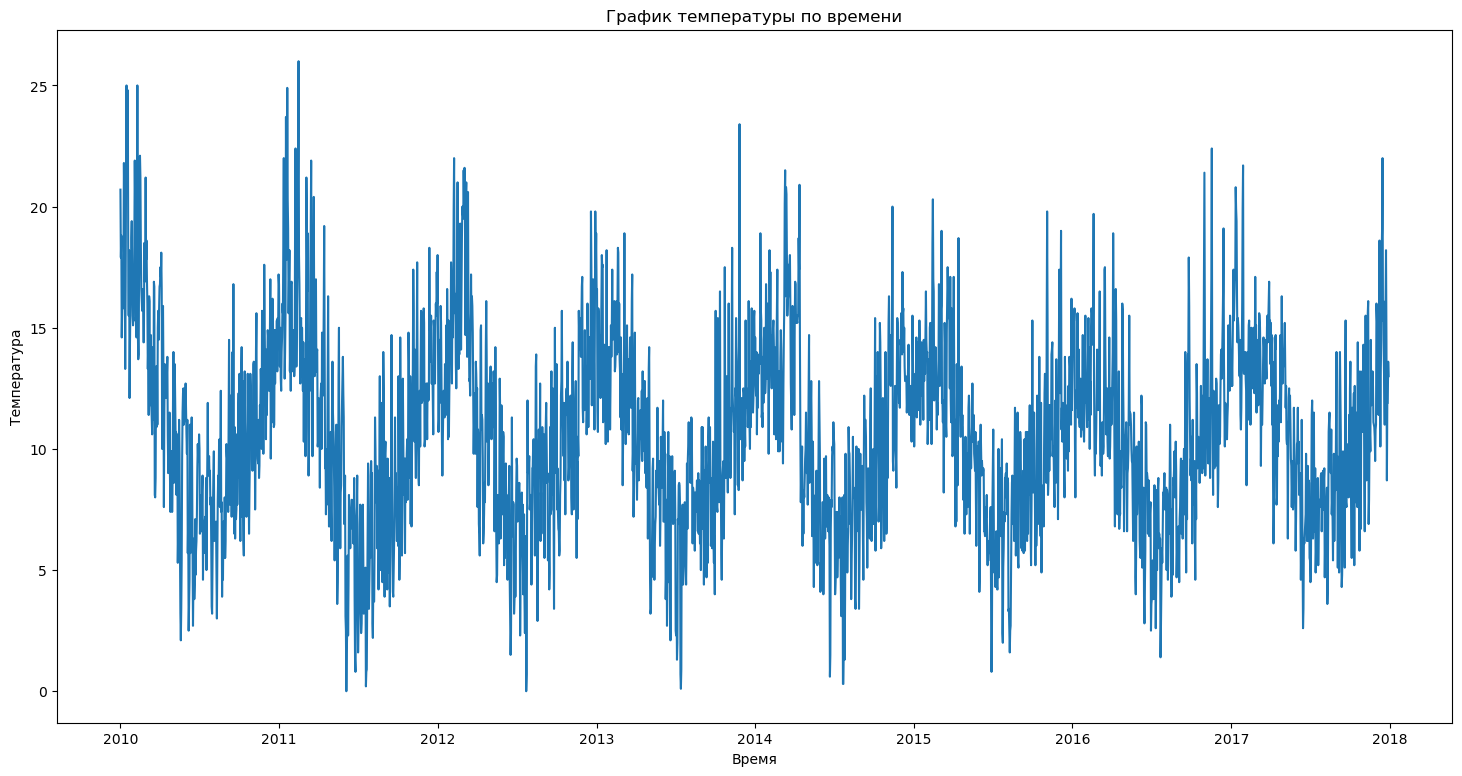

In [5]:
import matplotlib.pyplot as plt

df["Time"] = pd.to_datetime(df["Time"])
df.set_index("Time", inplace=True)
df.index.freq = 'D'

plt.figure(figsize=(18, 9))
plt.plot(df['Temperature'])
plt.title('График температуры по времени')
plt.xlabel('Время')
plt.ylabel('Температура')

plt.show()

Мы строим временной ряд температуры, чтобы визуально оценить наличие сезонности
На графике отчетливо видны сезонные колебания температуры

In [77]:
train_data

,y
Time,
2010-01-01,20.7
2010-01-02,17.9
2010-01-03,18.8
2010-01-04,14.6
2010-01-05,15.8
...,...
2016-12-25,15.1
2016-12-26,13.2
2016-12-27,13.3


In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Temperature"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('num of lags', result[2])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -4.24983216308537
p-value: 0.0005419750531920664
num of lags 19
Critical Values:
1%: -3.4326069302485953
5%: -2.8625371602624137
10%: -2.567300816765755


In [ ]:
Проверяем стационарность временного ряда температуры с помощью теста Дики-Фуллера
Если p-value меньше уровня значимости (обычно 0.05), то ряд стационарен
Если ADF Statistic больше критического значения, то ряд нестационарен
Количество лагов определяется автоматически
Критические значения приводятся для разных уровней значимости

Вывод:
Значение статистики ADF равно -4.25, что меньше критического значения для 1% уровня значимости (-3.43).
Это говорит о том, что мы можем отвергнуть нулевую гипотезу о наличии единичного корня с 99% уверенностью.
Значение p-value равно 0.00054, что также значительно меньше стандартных уровней значимости (0.01, 0.05, 0.10),
что дополнительно подтверждает стационарность временного ряда.
Таким образом, можно сделать вывод, что временной ряд температуры является стационарным, то есть не имеет тренда,
и его статистические свойства остаются постоянными во времени.
Что также можно увидеть на графике.

Корреляция с лагом 1: 0.7669120814466771


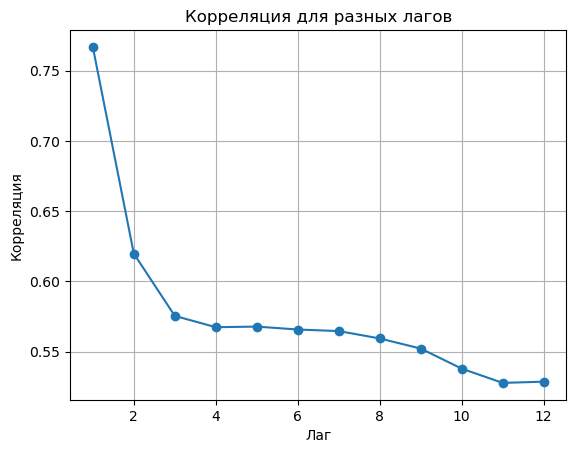

In [6]:
time_series = df["Temperature"]

# Вычислите корреляцию между данными и их лагами (значениями на предыдущих временных шагах)
lag_correlation = time_series.corr(time_series.shift(1))

# Выведите корреляцию
print("Корреляция с лагом 1:", lag_correlation)

# Постройте график корреляции для разных лагов
correlation_lags = [time_series.corr(time_series.shift(i)) for i in range(1, 13)]
plt.plot(range(1, 13), correlation_lags, marker='o')
plt.xlabel('Лаг')
plt.ylabel('Корреляция')
plt.title('Корреляция для разных лагов')
plt.grid(True)
plt.show()

Вывод:
Корреляция с лагом 1 составляет 0.77, что указывает на сильную положительную корреляцию между значениями температуры и их предыдущими значениями.
График корреляции для разных лагов показывает, что корреляция постепенно уменьшается с увеличением лага, но остается положительной даже для лага 12.
Это подтверждает наличие сезонности в данных температуры, поскольку значения температуры сильно коррелируют с предыдущими значениями на тех же временных интервалах в прошлом году.

In [10]:
# Вычисляем квартили
Q1 = np.percentile(df["Temperature"], 25)
Q3 = np.percentile(df["Temperature"], 75)

# Вычисляем межквартильный размах (IQR)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим выбросы
outliers = df[(df["Temperature"] < lower_bound) | (df["Temperature"] > upper_bound)]

print("Выбросы:")
print(outliers)

Выбросы:
            Time  Temperature
8     2010-01-09         21.8
13    2010-01-14         21.5
14    2010-01-15         25.0
17    2010-01-18         24.8
33    2010-02-03         21.9
39    2010-02-09         25.0
44    2010-02-14         22.0
45    2010-02-15         22.1
376   2011-01-12         22.0
381   2011-01-17         23.7
384   2011-01-20         24.9
403   2011-02-08         22.4
409   2011-02-14         22.5
410   2011-02-15         26.0
439   2011-03-16         21.9
768   2012-02-08         22.0
790   2012-03-01         21.5
792   2012-03-03         21.6
1425  2013-11-26         23.4
1530  2014-03-11         21.5
2512  2016-11-17         22.4
2584  2017-01-28         21.7
2905  2017-12-15         22.0


Для обнаружения выбросов используется метод межквартильного размаха (IQR).
Вычисляются первый (Q1) и третий (Q3) квартили, а также межквартильный размах (IQR = Q3 - Q1).
Границы для выбросов определяются как Q1 - 1.5 * IQR (нижняя граница) и Q3 + 1.5 * IQR (верхняя граница).
Значения температуры, выходящие за эти границы, считаются выбросами.
В результате обнаружено 23 выброса в данных температуры.
Наличие выбросов может быть вызвано ошибками измерений или экстремальными погодными условиями.
Выбросы могут оказывать влияние на результаты анализа и моделирования, поэтому их необходимо учитывать и сглаживать перед дальнейшей обработкой данных.

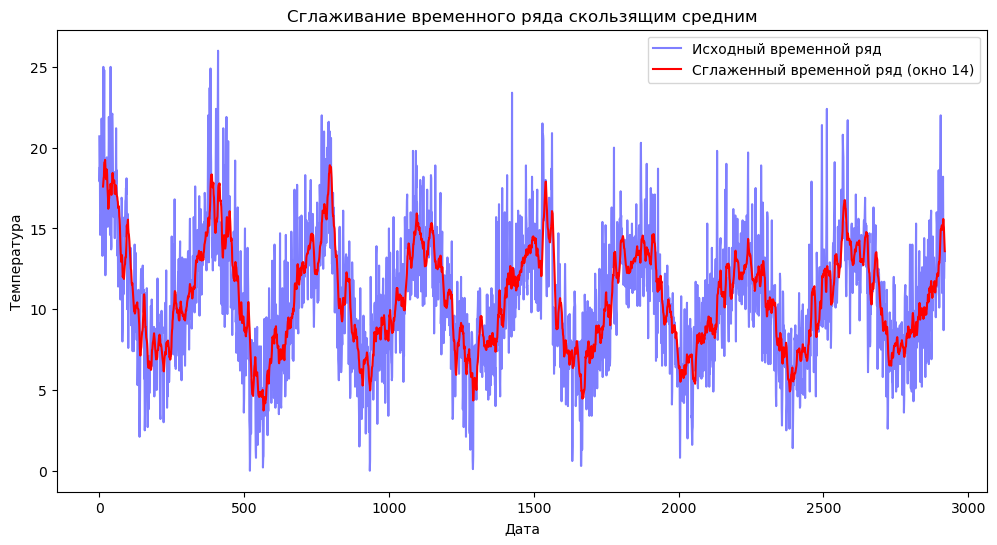

In [20]:
# Применяем скользящее среднее для сглаживания временного ряда
window_size = 14 # Размер окна для скользящего среднего
smoothed_series = df['Temperature'].rolling(window=window_size).mean()

# Строим графики исходного и сглаженного временных рядов
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature'], label='Исходный временной ряд', color='blue', alpha=0.5)
plt.plot(df.index, smoothed_series, label=f'Сглаженный временной ряд (окно {window_size})', color='red')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.title('Сглаживание временного ряда скользящим средним')
plt.show()


На графике представлены исходный и сглаженный временные ряды температуры.
Сглаживание выполняется с помощью скользящего среднего с размером окна 14 дней.
Скользящее среднее вычисляется для каждой точки временного ряда, усредняя значения в окрестности этой точки.
Сглаженный ряд имеет более плавный характер, поскольку высокочастотные колебания и шумы устранены.
Таким образом мы устраняем влияние выбросов.

In [179]:
smoothed_series = smoothed_series.dropna()

C:\Users\spot2\AppData\Local\Temp\ipykernel_6232\60262274.py:10: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  model = AutoReg(train_data, lags=19, old_names=True, seasonal=True, period=365)


Mean Absolute Error (MAE): 2.125681422691898
Mean Squared Error (MSE): 7.207017806158487
R-squared (R2): 0.4018117374545622


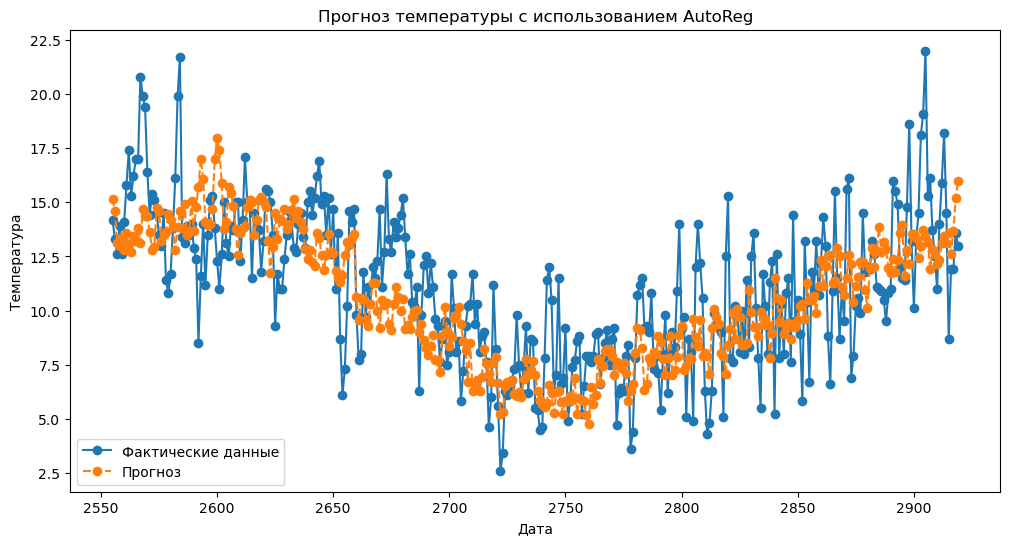

In [251]:
import pandas as pd
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = df['Temperature'][:-365]  
test_data = df['Temperature'][-365:]  

model = AutoReg(train_data, lags=19, old_names=True, seasonal=True, period=365)
model_fit = model.fit()

# Прогноз на тестовых данных
test_predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Рассчитаем
mae = mean_absolute_error(test_data, test_predictions)
mse = mean_squared_error(test_data, test_predictions)
r2 = r2_score(test_data, test_predictions)

# Выведем метрики
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Постройте графики
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Фактические данные', marker='o')
plt.plot(test_data.index, test_predictions, label='Прогноз', linestyle='--', marker='o')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.title('Прогноз температуры с использованием AutoReg')
plt.show()


В данном коде используется модель AutoReg из библиотеки statsmodels для прогнозирования временного ряда температуры.
Данные делятся на обучающую и тестовую выборки, где последние 365 значений используются для тестирования.
Модель AutoReg обучается на обучающей выборке с учетом 19 лагов и сезонности с периодом 365 дней.
Затем модель используется для прогнозирования на тестовой выборке.
Рассчитываются метрики качества прогноза: средняя абсолютная ошибка (MAE), среднеквадратичная ошибка (MSE) и коэффициент детерминации (R2).
Метрики выводятся в консоль.
Наконец, строятся графики фактических и прогнозных значений температуры для визуальной оценки качества прогноза.



Анализируя приведенные метрики качества прогноза:

Mean Absolute Error (MAE): 2.125

MAE показывает среднее абсолютное отклонение прогнозных значений от фактических. Значение 2.13 говорит о том, что в среднем прогноз отличается от реальных значений температуры на 2.13 градуса.
Mean Squared Error (MSE): 7.207

MSE является квадратом отклонений, поэтому ее значение всегда больше или равно MAE. Чем меньше MSE, тем лучше модель. Значение 7.21 можно считать относительно высоким, что указывает на наличие существенных отклонений прогноза от фактических данных.
R-squared (R2): 0.402

R2 показывает долю дисперсии зависимой переменной (температуры), которая объясняется моделью. Значение 0.4 говорит о том, что модель объясняет около 40% вариации температуры, что является не очень высоким показателем.
В целом, метрики указывают на среднее качество прогноза модели AutoReg для данного временного ряда температуры. Значения MAE и MSE являются достаточно высокими, что свидетельствует о существенных отклонениях прогноза от реальных данных. Коэффициент детерминации R2 также не слишком высок, что говорит о том, что модель не полностью учитывает все факторы, влияющие на температуру.

00:21:28 - cmdstanpy - INFO - Chain [1] start processing
00:21:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 1.9852588813341516
Mean Squared Error (MSE): 6.42419198101859
R-squared (R2): 0.4667869092677891


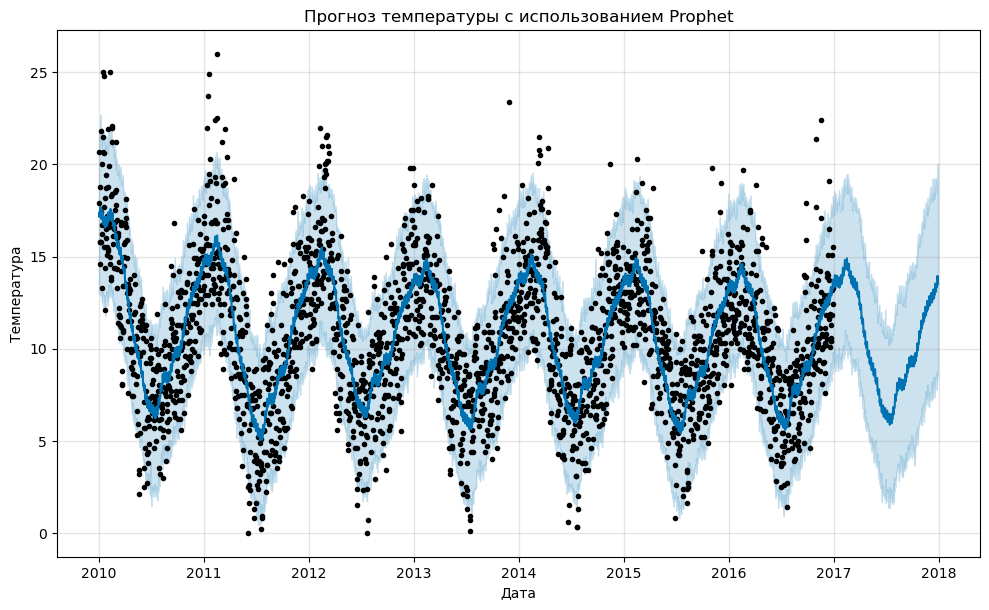

In [240]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Прочитать CSV-файл и создать объект DataFrame
csv_file_path = r"C:\Users\spot2\Downloads\temperature.csv"
df = pd.read_csv(csv_file_path)

# Разделите данные на обучающий и тестовый наборы
train_data = df.iloc[:-365]
test_data = df.iloc[-365:]

# Rename the columns to 'ds' and 'y'
train_data = train_data.rename(columns={'Time': 'ds', 'Temperature': 'y'})
test_data = test_data.rename(columns={'Time': 'ds', 'Temperature': 'y'})


# Инициализируйте и обучите модель Prophet
model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    seasonality_mode='additive',
    seasonality_prior_scale=100.0,
    changepoint_prior_scale=0.5,
    interval_width=0.9,
    uncertainty_samples=365
)

model.fit(train_data)

# Создайте DataFrame для прогноза
future = model.make_future_dataframe(periods=len(test_data))

# Получите прогноз
forecast = model.predict(future)

# Извлеките прогнозные значения
test_predictions = forecast['yhat'][-len(test_data):]

# Рассчитайте метрики
mae = mean_absolute_error(test_data['y'], test_predictions)
mse = mean_squared_error(test_data['y'], test_predictions)
r2 = r2_score(test_data['y'], test_predictions)

# Выведите метрики
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Постройте графики
fig = model.plot(forecast)
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.title('Прогноз температуры с использованием Prophet')
plt.show()


В данном коде используется библиотека Prophet для прогнозирования временного ряда температуры.
Данные разделяются на обучающую и тестовую выборки, где последние 365 значений используются для тестирования.
Столбцы данных переименовываются в соответствии с требованиями Prophet ('ds' для даты и 'y' для целевой переменной).
Инициализируется и обучается модель Prophet с заданными параметрами, включая линейный рост, годовую сезонность и другие настройки.
Создается DataFrame для прогноза на основе тестового периода.
Делается прогноз с помощью обученной модели.

Проанализируем полученные метрики качества прогноза с использованием модели Prophet:

Mean Absolute Error (MAE): 1.985

MAE показывает, что в среднем прогнозные значения отклоняются от фактических на 1.99 градуса. Это значение немного лучше, чем у предыдущей модели AutoReg (2.13).
Mean Squared Error (MSE): 6.424

MSE также несколько улучшилось по сравнению с моделью AutoReg (7.21). Чем ниже MSE, тем лучше модель описывает данные.
R-squared (R2): 0.467

Коэффициент детерминации R2 вырос до 0.47, что говорит о том, что модель Prophet объясняет около 47% вариации температуры. Это немного лучше, чем у модели AutoReg (0.40).
В целом, модель Prophet показывает лучшие результаты прогнозирования временного ряда температуры по сравнению с моделью AutoReg. Все три метрики (MAE, MSE и R2) улучшились, хотя и не слишком значительно.

Преимущество модели Prophet заключается в том, что она специально разработана для прогнозирования временных рядов с сезонностью и холидеями, и может автоматически выявлять изменения трендов (changepoints). Кроме того, Prophet имеет встроенные функции для визуализации прогнозов и интервалов неопределенности.

In [ ]:
Вывод:
Несмотря на то, что модель Prophet показывает лучшие результаты по сравнению с моделью AutoReg, качество прогноза все еще остается средним.
Это может быть связано с тем, что для корректного прогнозирования температуры недостаточно использовать только исторические данные.
Температура зависит от множества факторов, таких как атмосферное давление, влажность, облачность, ветер и другие метеорологические переменные.
Для повышения точности прогноза необходимо учитывать эти дополнительные факторы, которые могут влиять на температуру.
Включение релевантных экзогенных переменных в модель может значительно улучшить ее предсказательную способность.

In [91]:
forecast_data = forecast_data.rename(columns={'ds': 'day', 'yhat': 'temperature'})
forecast_data.to_csv('forecasted_temperature.csv', index=False)